This is the first part of my work on California Housing Dataset, which I did on Kaggle in September 2020.

I roughly followed the second chapter of the Hands-On Machine Learning Handbooks, but also came up with many ideas on my own.

In this notebook I did the following:

1. Feature Engineering.

Besides the very simple ones inspired by what I found in the handbook (bedrooms_fraction and so on) I realized that there are two "price hotspots"–geographical areas in which the highest prices tend to cluster. I explored this possible dependence and wrote code to calculate the precise location of these hotspots and the distance of each district from the hotspot that's closer to it. This new feature (which I named center_distance) is highly negatively correlated (-0.54) with the variable that I was trying to predict, i.e. the median prices of a house in a given district (median_house_value).

The other engineered feature I created was the distance of a district from the ocean. This new variable, ocean_distance, also turned out to be highly negatively correlated (-0.49) with median_house_value.

2. Created a pipeline with custom transformers that does the following:

    1) Removes the rows with "capped" values in housing_median_age and median_house_value columns (i.e. rows which initially probably contained very high values but were then "rounded" or "cut" down to some pre-set value (52 for median_housing_age and 500001 for median_house_value)
    
    2) Calculates the distance from the ocean (ocean_distance, described above)
    
    3) Imputes values missing from the total_bedrooms column
    
    4) Calculates the distance from the closest center (center_distance, described above)
    
    5) One-hot encodes the categorical variable ocean_proximity
    
    6) Adds several new potentially valuable attributes
    
    6) Normalizes all the numerical data
    
3. Tested three popular models provided by Scikit-learn library with their default values as well as a simple neural network.

For all the Scikit-learn's models tested, I achieved significantly better scores than reported in the handbook, which points to the predictive power of my engineered features.

The neural network achieved the best score of all the models tested, RMSE = 41682, whereas for RandomForestRegressor (second best) RMSE=52435.

I'm going to continue working on this dataset (especially with regards to developing and fine-tuning better models) in a separate notebook, which soon will be also available at my GitHub and Kaggle pages.

# 0. Import stuff

In [1]:
# Basic stuff
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

# Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# Models, metrics etc
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cvs
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, utils, callbacks

In [2]:
housing_dir = '../input/california-housing-prices/housing.csv'
data = pd.read_csv(housing_dir)
data.shape, data.columns

((20640, 10),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'))

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 1. EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


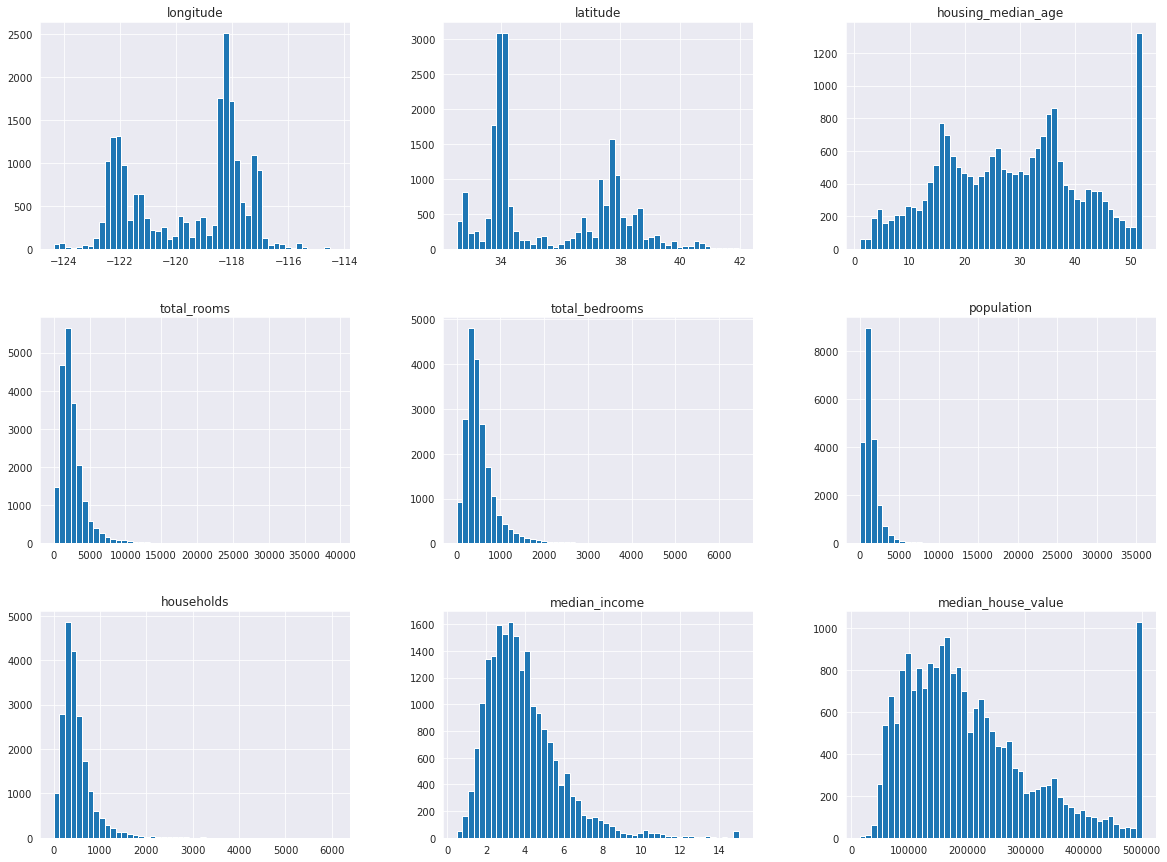

In [8]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
corr_mat = data.corr()
corr_mat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [10]:
corr_list = []
for i, f1 in enumerate(data.columns[:-1]):
    for f2 in data.columns[i+1:-1]:
        corr_list.append([corr_mat.loc[f1,f2], f1, f2])
corr_list = pd.DataFrame(corr_list, columns=['Correlation value', 'Feature 1', 'Feature 2']).sort_values(by='Correlation value').reset_index(drop=True)
corr_list

,Correlation value,Feature 1,Feature 2
0,-0.924664,longitude,latitude
1,-0.361262,housing_median_age,total_rooms
2,-0.320451,housing_median_age,total_bedrooms
3,-0.302916,housing_median_age,households
4,-0.296244,housing_median_age,population
5,-0.144160,latitude,median_house_value
6,-0.119034,housing_median_age,median_income
7,-0.108785,latitude,population
8,-0.108197,longitude,housing_median_age
9,-0.079809,latitude,median_income


In [11]:
corr_price = corr_list.query(' `Feature 1`=="median_house_value" | `Feature 2`=="median_house_value" ').reset_index(drop=True)
corr_price

,Correlation value,Feature 1,Feature 2
0,-0.144160,latitude,median_house_value
1,-0.045967,longitude,median_house_value
2,-0.024650,population,median_house_value
3,0.049686,total_bedrooms,median_house_value
4,0.065843,households,median_house_value
5,0.105623,housing_median_age,median_house_value
6,0.134153,total_rooms,median_house_value
7,0.688075,median_income,median_house_value


# 2. Data Cleaning

## 2.1. Dealing with NaNs

In [12]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

There are 207 NaNs (not-a-numbers, a.k.a. missing values) in the total_bedrooms column. We will replace them with the median number of bedrooms:

In [17]:
print("Before: %i NaNs" % data['total_bedrooms'].isnull().sum())

data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace=True)

print("After: %i NaNs" % data['total_bedrooms'].isnull().sum())


Before: 0 NaNs
After: 0 NaNs


# 2.2. Removing "lines" and "cappings"

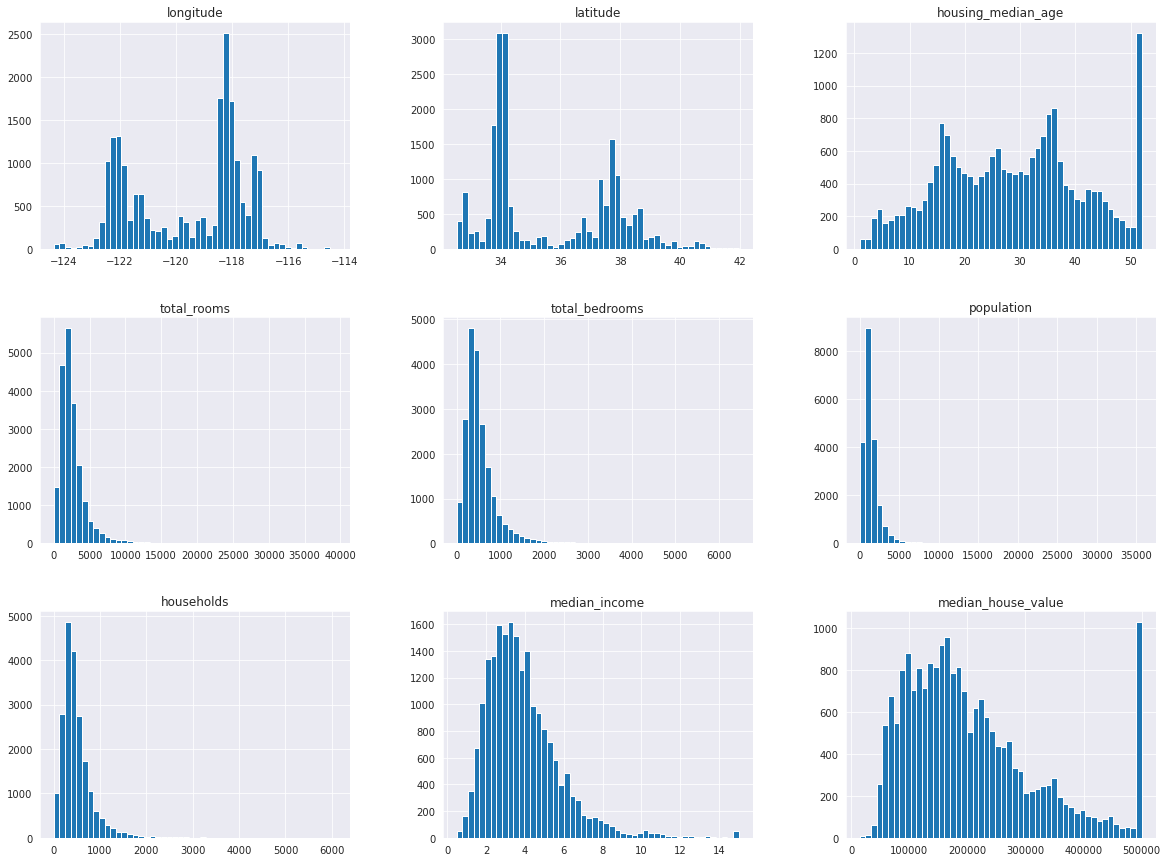

In [18]:
data.hist(bins=50, figsize=(20,15))
plt.show()

These "skyscrappers" at the right end of median_house_value and housing_median_age histograms clearly indicate, that this data was capped – the most expensive households were "rounded down" to the value of $500.000. Similarly for households older than 50 years. Since we cannot retrieve the original values, we need to get rid of this instances:

## 2.2.1. The ordinary way

We could do it just by dropping these rows with a .drop() method...

In [19]:
print("Before: %i datapoints." % data.shape[0])

data_cleaned_1 = data.drop(
    index = data.query(' `median_house_value` >= 500000 | `housing_median_age` >= 50 ').index.values,
    inplace = False
)

print("After: %i datapoints." % data_cleaned_1.shape[0])

Before: 20640 datapoints.
After: 18388 datapoints.


(we've lost over 10% of our original data)

... or we could use a custom transformer, which would allow us to include this step in a pipeline:

In [20]:
mhv_ix, hma_ix = 8, 2
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy() # To make sure that we don't change the original DataFrame
        X_cleaned = X.drop(index = data.query(' `median_house_value` >= 500000 | `housing_median_age` >= 50 ').index.values)
        return X_cleaned
    
outlier_remover = OutlierRemover()
data_cleaned_2 = outlier_remover.transform(data)
data_cleaned_2.shape

(18388, 10)

We can check that the two ways are perfectly equivalent:

In [21]:
np.all(data_cleaned_1 == data_cleaned_2)

True

In [22]:
data = outlier_remover.transform(data)

There is one more data-cleaning problem left:

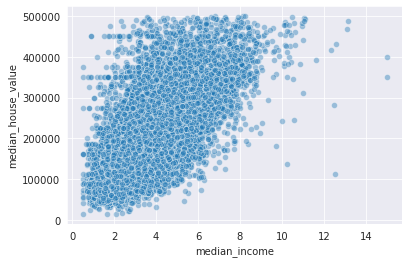

In [23]:
sns.scatterplot(
    x='median_income', y='median_house_value',
    alpha=.4,
    data=data
)

In a very suspicious way, datapoints tend to aggreagate along some precise, discrete values of median_house_value variable: 45.000, 35.000, 28.000... It looks like their original values were much more dispersed, but similar (though originally different) values were lumped together into discrete categories before being included in our data.

In [24]:
mhv_counts = data['median_house_value'].value_counts().sort_index()
mhv_counts.loc[448000:452000]

448100.0     1
448300.0     1
450000.0    30
450400.0     3
450700.0     3
450800.0     1
451100.0     1
451300.0     3
451400.0     2
451500.0     1
451700.0     1
451800.0     1
Name: median_house_value, dtype: int64

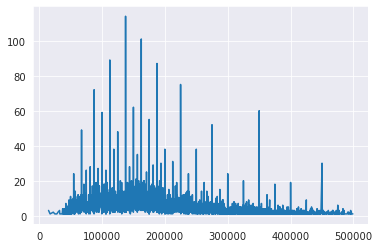

In [25]:
x = mhv_counts.index
y = mhv_counts.values

plt.plot(x, y)
plt.show()

The above plot clearly shows that there are many more such "lumpings" in the data. Removing this values, however would mean losing a lot of data, so I'm going to leave it there for now. 

Possible options:

* Remove the "lumpings"
* Add some random noise to this "lumpings"

# 3. Data encoding

There is one categorical variable in the data: ocean_proximity. Since Machine Learning algorithms can deal only with data represented numerically, we need to perform one-hot encoding.

For that we will use Scikit-learn's OneHotEncoder:

In [26]:
print(data['ocean_proximity'].value_counts())

encoder = OneHotEncoder()
#data_op = data[['ocean_proximity']]
op_ohe = encoder.fit_transform(data[['ocean_proximity']]).toarray()

op_ohe, op_ohe.shape

<1H OCEAN     8262
INLAND        6306
NEAR OCEAN    2300
NEAR BAY      1518
ISLAND           2
Name: ocean_proximity, dtype: int64


(array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 (18388, 5))

In [27]:
for category_i, category in enumerate(encoder.categories_[0]):
    print(category_i, category, data['ocean_proximity'].value_counts()[category], op_ohe[:,category_i].sum())

0 <1H OCEAN 8262 8262.0
1 INLAND 6306 6306.0
2 ISLAND 2 2.0
3 NEAR BAY 1518 1518.0
4 NEAR OCEAN 2300 2300.0


In [28]:
for category_i, category in enumerate(encoder.categories_[0]):
    data[category] = op_ohe[:, category_i]

In [29]:
data.loc[:, 'ocean_proximity':]

,ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
1,NEAR BAY,0.0,0.0,0.0,1.0,0.0
8,NEAR BAY,0.0,0.0,0.0,1.0,0.0
20,NEAR BAY,0.0,0.0,0.0,1.0,0.0
21,NEAR BAY,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
20635,INLAND,0.0,1.0,0.0,0.0,0.0
20636,INLAND,0.0,1.0,0.0,0.0,0.0
20637,INLAND,0.0,1.0,0.0,0.0,0.0
20638,INLAND,0.0,1.0,0.0,0.0,0.0


Thus encoded categorical data could be easily fed to a machine learning model. I think, however, that there is a way to extract a more precise information regarding ocean proximity, which will make these one-hot-encoded data redundant. We will do that in section 4.3.

# 4. Feature Engineering

Here we will create new features for our dataset by processing/combining the original ones. Hopefully they will turn out to be more predictive of the value we want to measure. i.e. median_house_value.

## 4.1. Simple combined features

Total number of rooms or bedroom in a given district don't tell us much by themselves. They much more informative when expressed in relation to this district's population or total number of households. Another possibly interesting featuer may be the fraction of all rooms being bedrooms.

* rooms_per_household, bedrooms_per_household

* rooms_per_person, bedrooms_per_person

* bedrooms_fraction

## 4.1.1. Combining features the vanilla way

We can add this features in a very simple way, one by one, like this:

In [30]:
data_expanded_1 = data.copy()

data_expanded_1['rooms_per_household'] = data_expanded_1['total_rooms'] / data_expanded_1['households']
data_expanded_1['bedrooms_per_household'] = data_expanded_1['total_bedrooms'] / data_expanded_1['households']

data_expanded_1['rooms_per_person'] = data_expanded_1['total_rooms'] / data_expanded_1['population']
data_expanded_1['bedrooms_per_person'] = data_expanded_1['total_bedrooms'] / data_expanded_1['population']

data_expanded_1['bedrooms_fraction'] = data_expanded_1['total_bedrooms'] / data_expanded_1['total_rooms']

data_expanded_1['people_per_household'] = data_expanded_1['population'] / data_expanded_1['households']

data_expanded_1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_household,rooms_per_person,bedrooms_per_person,bedrooms_fraction,people_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,0.0,0.0,1.0,0.0,6.984127,1.023810,2.732919,0.400621,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,0.0,0.0,1.0,0.0,6.238137,0.971880,2.956685,0.460641,0.155797,2.109842
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.294118,1.117647,2.118574,0.551410,0.260274,2.026891
20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.524096,1.108434,1.836186,0.449878,0.245007,2.463855
21,-122.27,37.85,42.0,1639.0,367.0,929.0,366.0,1.7135,159800.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.478142,1.002732,1.764263,0.395048,0.223917,2.538251


## 4.1.2. Combining features the "fancy" way

... or we could use a custom transfomer, like the one below, based on the one from the second chapter of Hands-On Machine Learning notebook:

In [33]:
# Names of the new features/columns
new_features = [
    'rooms_per_household',
    'bedrooms_per_household',
    'rooms_per_person',
    'bedrooms_per_person',
    'bedrooms_fraction',
    'people_per_household'
]
class FeatExpander(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_household'] = X['total_bedrooms'] / X['households']
        X['rooms_per_person'] = X['total_rooms'] / X['population']
        X['bedrooms_per_person'] = X['total_bedrooms'] / X['population']
        X['bedrooms_fraction'] = X['total_bedrooms'] / X['total_rooms']
        X['people_per_households'] = X['population'] / X['households']
        return X
    
feat_expander = FeatExpander()
data_expanded_2 = feat_expander.transform(data)

data_expanded_2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_household,rooms_per_person,bedrooms_per_person,bedrooms_fraction,people_per_households
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,0.0,0.0,1.0,0.0,6.984127,1.023810,2.732919,0.400621,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,0.0,0.0,1.0,0.0,6.238137,0.971880,2.956685,0.460641,0.155797,2.109842
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.294118,1.117647,2.118574,0.551410,0.260274,2.026891
20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.524096,1.108434,1.836186,0.449878,0.245007,2.463855
21,-122.27,37.85,42.0,1639.0,367.0,929.0,366.0,1.7135,159800.0,NEAR BAY,...,0.0,0.0,1.0,0.0,4.478142,1.002732,1.764263,0.395048,0.223917,2.538251


We can check that the two ways of adding new features are perfectly equivalent:

In [34]:
np.all(data_expanded_1.index == data_expanded_2.index)

True

In [36]:
data = feat_expander.fit_transform(data)
data.corr()['median_house_value']

longitude                -0.024153
latitude                 -0.170769
housing_median_age        0.013918
total_rooms               0.154073
total_bedrooms            0.079189
population                0.022854
households                0.100428
median_income             0.664728
median_house_value        1.000000
<1H OCEAN                 0.318324
INLAND                   -0.502004
ISLAND                    0.019641
NEAR BAY                  0.112783
NEAR OCEAN                0.147250
rooms_per_household       0.115276
bedrooms_per_household   -0.062938
rooms_per_person          0.155826
bedrooms_per_person       0.035131
bedrooms_fraction        -0.221497
people_per_households    -0.020056
Name: median_house_value, dtype: float64

bedrooms_fraction is quite highly negatively correlated with median_house_value.

rooms_per_person and rooms_per_household also may turn out to be useful predictors.

Transformations we performed so far can be combined into the following pipeline. We use ColumnTransformer to separate transformations performed on the categorical attribute (ocean_proximity) from those performed on the numerical attributes (all the rest).

(the only difference is that using this pipeline we are going to drop the ocean_proximity attribute, but that's okay)

In [46]:
# Re-load the original data
data_original = pd.read_csv(housing_dir)

# Separate the numerical part of the data
data_num = data_original.drop('ocean_proximity', axis=1)

# Names of the numerical attributes in the original data
attribs_num = data_num.columns.tolist()

# Name of the only categorical attribute in the original data
attribs_cat = ['ocean_proximity']

# I initialize an encoder here only to extract the list of labels in the same order in which they will be given later in the pipeline
encoder = OneHotEncoder()
encoder.fit(data[attribs_cat])
oh_labels = encoder.categories_[0].tolist()

# Names of the attributes added by FeatExpander
new_features = [
    'rooms_per_household',
    'bedrooms_per_household',
    'rooms_per_person',
    'bedrooms_per_person',
    'bedrooms_fraction',
    'people_per_household'
]

# Names of columns needed for reconversion of the numpy array returned by column_transformer back into a DataFrame
columns_tr = [*attribs_num, *new_features, *oh_labels]


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy() # To make sure that we don't change the original DataFrame
        X_cleaned = X.drop(index = X.query(' `median_house_value` >= 500000 | `housing_median_age` >= 50 ').index.values)
        return X_cleaned

# I made my own imputer, because Scikit-learn's SimpleImputer returns a numpy array, whereas I prefer working on DataFrames
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['total_bedrooms'].fillna(value=X['total_bedrooms'].median(), inplace=True)
        return X
        

class FeatExpander(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_household'] = X['total_bedrooms'] / X['households']
        X['rooms_per_person'] = X['total_rooms'] / X['population']
        X['bedrooms_per_person'] = X['total_bedrooms'] / X['population']
        X['bedrooms_fraction'] = X['total_bedrooms'] / X['total_rooms']
        X['people_per_households'] = X['population'] / X['households']
        return X
    
# Another custom transformer - just to reconvert NumPy arrays returned by column_transformer back into a DataFrame
class DFConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X_df = pd.DataFrame(X)
        X_df.columns = columns_tr #
        return X_df

# A pipeline for numerical attributes
pipeline_num = Pipeline([
    ('imputer', MyImputer()),
    ('feat_expander', FeatExpander()),
])


column_transformer = ColumnTransformer([
    ('num', pipeline_num, attribs_num), # For the numerical attributes
    ('cat', OneHotEncoder(), attribs_cat), # For the categorical attribute
])

pipeline_full = Pipeline([
    ('outlier_remover', OutlierRemover()), # Remove the outliers
    ('column_transformer', column_transformer), # Process the numerical attributes and the categorical attribute separately and concatenate them after
    ('df_converter', DFConverter()) # Reconvert the concatenated NumPy array back into a DataFrame
])

data_tr = pipeline_full.fit_transform(data_original)
data_tr.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_household',
       'rooms_per_person', 'bedrooms_per_person', 'bedrooms_fraction',
       'people_per_household', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')

## 4.2. center_distance - A distance from an area of high price

A quick look at the heatmap displaying median_house_value on a longitude/latitude plot indicates that there are two major "centers" distinguished by exceptionally high prices:

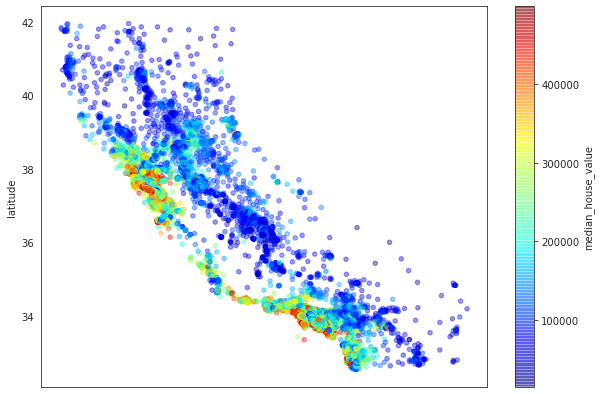

In [52]:
sns.set_style('white')

data.plot(
    x='longitude', y='latitude',
    kind='scatter', figsize=(10,7),
    alpha=.4,
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
)

In [53]:
corr_mhv = data.corr()['median_house_value'].sort_values(ascending=False)
corr_mhv

median_house_value        1.000000
median_income             0.664728
<1H OCEAN                 0.318324
rooms_per_person          0.155826
total_rooms               0.154073
NEAR OCEAN                0.147250
rooms_per_household       0.115276
NEAR BAY                  0.112783
households                0.100428
total_bedrooms            0.079189
bedrooms_per_person       0.035131
population                0.022854
ISLAND                    0.019641
housing_median_age        0.013918
people_per_households    -0.020056
longitude                -0.024153
bedrooms_per_household   -0.062938
latitude                 -0.170769
bedrooms_fraction        -0.221497
INLAND                   -0.502004
Name: median_house_value, dtype: float64

There is no significant simple, linear correlation between longitude and median_house_value. Latitude is weakly negatively correlated. However, if we plot longitude and latitude against median_house_value we can see that there is possibly a more complex, less-obvious, non-linear trend.

This can be especially evident, when we overlay a lineplot (in red) of mean median_house_value for all the districts placed along a particular longitude/latitude (in blue).

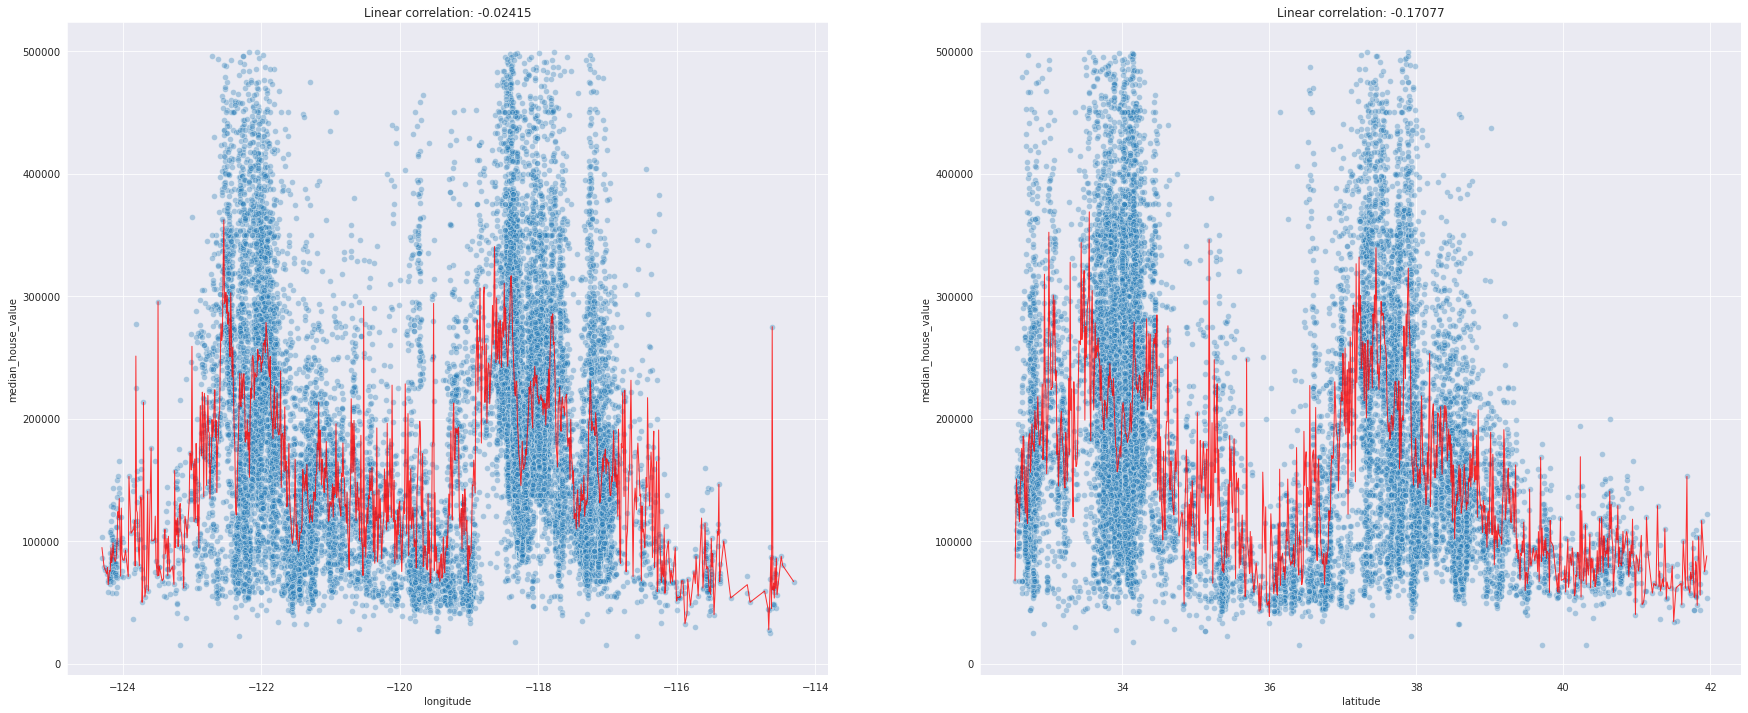

In [54]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1,2, figsize=(30,12))

sns.scatterplot(
    x = 'longitude', y = 'median_house_value',
    alpha=.33,
    data=data, ax=ax[0]
)
sns.lineplot(
    x='longitude', y='median_house_value',
    ci=None, color='red', linewidth=1, alpha=.8,
    data=data, ax=ax[0]
)
ax[0].set_title('Linear correlation: %.5f' % (data.corr().loc['median_house_value', 'longitude']))

sns.scatterplot(
    x = 'latitude', y = 'median_house_value',
    alpha=.33,
    data=data, ax=ax[1]
)
sns.lineplot(
    x='latitude', y='median_house_value',
    ci=None, color='red', linewidth=1, alpha=.8,
    data=data, ax=ax[1]
)
ax[1].set_title('Linear correlation: %.5f' % (data.corr().loc['median_house_value', 'latitude']))

plt.show()

So, while there is no significant linear correlation between median_house_value and longitude, there seem to be two high-price regions: one around -122 and the another around -118 longitude. The same goes for 33 and 37 latitude. Moreover, a quick look at the previous map indicates that the two are not independent. 


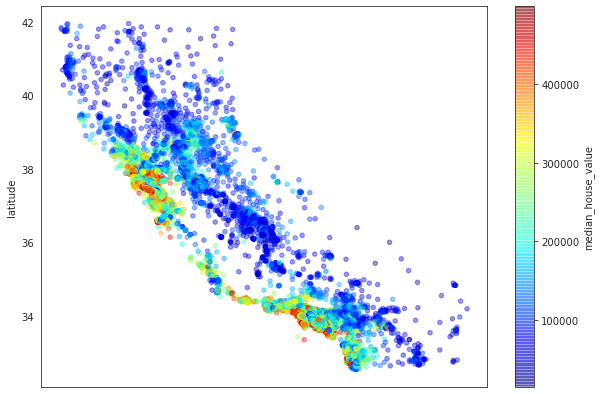

In [55]:
sns.set_style('white')

data.plot(
    x='longitude', y='latitude',
    kind='scatter', figsize=(10,7),
    alpha=.4,
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
)

So there two high-price regions:

1) North-western (NW): around longitude -122 and latitude 37

2) South-eastern (SE): around longitude -118 and latitude 35

Distance from these hotspots or centers may be highly correlated with median_house_value.

We could settle at these roughly estimated values. This, however does not satisfy us and we're going to search for them methodically.

First, we will look for two longitude values, distances from which are most highly correlated with median_house_value. Then we will do the same for latitude. After that, we will combine the results into two pairs of coordinates, one for each high-price hotspot and perform a little fine-tuning.

### 4.2.1. Longitude

In [56]:
center_NW_long = [0, 0] # correlation, longitude
center_SE_long = [0, 0] # ^
inter_center_long = -120 # longitude

while True:
    print(inter_center_long)
    data_NW = data.copy().query('longitude < @inter_center_long')
    data_SE = data.copy().query('longitude > @inter_center_long')
    
    # center_NW
    for long_val in tqdm(np.arange(-124, inter_center_long, .01)):
        data_NW['center_NW_long'] = data_NW['longitude'].apply(lambda x: abs(long_val-x))
        correlation = data_NW.corr().loc['center_NW_long', 'median_house_value']
        if abs(correlation)>abs(center_NW_long[0]):
            center_NW_long = [correlation, long_val]
    
    # center_SE
    for long_val in tqdm(np.arange(inter_center_long, -116, .01)):
        data_SE['center_SE_long'] = data_SE['longitude'].apply(lambda x: abs(long_val-x))
        correlation = data_SE.corr().loc['center_SE_long', 'median_house_value']
        if abs(correlation)>abs(center_SE_long[0]):
            center_SE_long = [correlation, long_val]
            
    # inter_center
    new_inter_center_long = (center_NW_long[1]+center_SE_long[1])/2# [(center_NW[1]+center_SE[1])/2, (center_NW[2]+center_SE[2])/2]
    if new_inter_center_long!=inter_center_long:
        inter_center_long = new_inter_center_long
    else:
        break

center_NW_long, center_SE_long

  2%|▏         | 7/400 [00:00<00:06, 62.71it/s]

-120


  2%|▏         | 7/369 [00:00<00:05, 64.95it/s]

-120.31999999999914


  2%|▏         | 6/369 [00:00<00:06, 57.13it/s]

-120.31999999999863


100%|██████████| 432/432 [00:11<00:00, 38.05it/s]


([-0.4114463801644442, -122.25999999999911],
 [-0.3601258746927139, -118.37999999999815])

### 4.2.2. Latitude

In [57]:
center_NW_lat = [0, 0] # correlation, latitude
center_SE_lat = [0, 0] # ^
inter_center_lat = 36 # latitude

while True:
    print(inter_center_lat)
    data_NW = data.copy().query('latitude > @inter_center_lat')
    data_SE = data.copy().query('latitude < @inter_center_lat')
    
    # center_NW
    for lat_val in tqdm(np.arange(inter_center_lat, inter_center_lat+2, .01)):
        data_NW['center_NW_lat'] = data_NW['latitude'].apply(lambda x: abs(lat_val-x))
        correlation = data_NW.corr().loc['center_NW_lat', 'median_house_value']
        if abs(correlation)>abs(center_NW_lat[0]):
            center_NW_lat = [correlation, lat_val]
    
    # center_SE
    for lat_val in tqdm(np.arange(inter_center_lat-2, inter_center_lat, .01)):
        data_SE['center_SE_lat'] = data_SE['latitude'].apply(lambda x: abs(lat_val-x))
        correlation = data_SE.corr().loc['center_SE_lat', 'median_house_value']
        if abs(correlation)>abs(center_SE_lat[0]):
            center_SE_lat = [correlation, lat_val]
            
    # inter_center
    new_inter_center_lat = (center_NW_lat[1]+center_SE_lat[1])/2# [(center_NW[1]+center_SE[1])/2, (center_NW[2]+center_SE[2])/2]
    if new_inter_center_lat!=inter_center_lat:
        inter_center_lat = new_inter_center_lat
    else:
        break

center_NW_lat, center_SE_lat

  3%|▎         | 6/200 [00:00<00:03, 57.00it/s]

36


  3%|▎         | 6/200 [00:00<00:03, 57.81it/s]

35.764999999999844


  2%|▎         | 5/200 [00:00<00:03, 49.21it/s]

35.649999999999665


  3%|▎         | 6/200 [00:00<00:03, 57.45it/s]

35.58999999999948


  3%|▎         | 6/200 [00:00<00:03, 51.58it/s]

35.58999999999938


100%|██████████| 200/200 [00:04<00:00, 41.97it/s]


([-0.45836772865207476, 37.52999999999909],
 [-0.23077159056922136, 33.649999999999665])

In [58]:
center_NW_long, center_NW_lat, center_SE_long, center_SE_lat

([-0.4114463801644442, -122.25999999999911],
 [-0.45836772865207476, 37.52999999999909],
 [-0.3601258746927139, -118.37999999999815],
 [-0.23077159056922136, 33.649999999999665])

## 4.2.3. Longitude + latitude

In [59]:
center_NW = [center_NW_long[1], center_NW_lat[1]] # longitude, latitude
center_SE = [center_SE_long[1], center_SE_lat[1]] # ^

inter_center = [inter_center_long, inter_center_lat] # ^

new_center_NW = [0, 0, 0]   # correlation, longitude, latitue
new_center_SE = [0, 0, 0]   # ^

# center_NW
data_NW = data.copy().query('longitude < @inter_center[0] & latitude > @inter_center[1]')
for long_val in tqdm(np.arange(center_NW[0]-.5, center_NW[0]+.5, .05)):
    for lat_val in np.arange(center_NW[1]-.5, center_NW[1]+.5, .05):
        data_NW['center_NW_distance'] = data_NW.apply(lambda x: np.sqrt((x['longitude']-long_val)**2 + (x['latitude']-lat_val)**2), axis=1)
        correlation = data_NW.corr().loc['center_NW_distance', 'median_house_value']
        if abs(correlation)>abs(new_center_NW[0]):
            new_center_NW = [correlation, long_val, lat_val]
            
# center_SE
data_SE = data.copy().query('longitude > @inter_center[0] & latitude < @inter_center[1]')
for long_val in tqdm(np.arange(center_SE[0]-.5, center_SE[0]+.5, .05)):
    for lat_val in np.arange(center_SE[1]-.5, center_SE[1]+.5, .05):
        data_SE['center_SE_distance'] = data_SE.apply(lambda x: np.sqrt((x['longitude']-long_val)**2 + (x['latitude']-lat_val)**2), axis=1)
        correlation = data_SE.corr().loc['center_SE_distance', 'median_house_value']
        if abs(correlation)>abs(new_center_SE[0]):
            new_center_SE = [correlation, long_val, lat_val]

# inter_center
inter_center = [(new_center_NW[1]+new_center_SE[1])/2, (new_center_NW[2]+new_center_SE[2])/2]

print("inter_center:\t", inter_center)
print("NW:\t", new_center_NW)
print("SE:\t", new_center_SE)

100%|██████████| 20/20 [02:08<00:00,  6.40s/it]

inter_center:	 [-120.81999999999863, 35.08999999999938]
NW:	 [-0.6084623684077485, -122.75999999999911, 37.02999999999909]
SE:	 [-0.40879270522844247, -118.87999999999815, 33.149999999999665]


In [60]:
center_NW = new_center_NW[1:] # longitude, latitude
center_SE = new_center_SE[1:] # ^


## center_NW
data_NW = data.copy().query('longitude < @inter_center[0] & latitude > @inter_center[1]')
for long_val in tqdm(np.arange(center_NW[0]-.05, center_NW[0]+.05, .01)):
    for lat_val in np.arange(center_NW[1]-.05, center_NW[1]+.05, .01):
        data_NW['center_NW_distance'] = data_NW.apply(lambda x: np.sqrt((x['longitude']-long_val)**2 + (x['latitude']-lat_val)**2), axis=1)
        correlation = data_NW.corr().loc['center_NW_distance', 'median_house_value']
        if abs(correlation)>abs(new_center_NW[0]):
            new_center_NW = [correlation, long_val, lat_val]
            
# center_SE
data_SE = data.copy().query('longitude > @inter_center[0] & latitude < @inter_center[1]')
for long_val in tqdm(np.arange(center_SE[0]-.05, center_SE[0]+.05, .01)):
    for lat_val in np.arange(center_SE[1]-.05, center_SE[1]+.05, .01):
        data_SE['center_SE_distance'] = data_SE.apply(lambda x: np.sqrt((x['longitude']-long_val)**2 + (x['latitude']-lat_val)**2), axis=1)
        correlation = data_SE.corr().loc['center_SE_distance', 'median_house_value']
        if abs(correlation)>abs(new_center_SE[0]):
            new_center_SE = [correlation, long_val, lat_val]

# inter_center
inter_center = [(new_center_NW[1]+new_center_SE[1])/2, (new_center_NW[2]+new_center_SE[2])/2]
print("inter_center:\t", inter_center)

print("NW:\t", new_center_NW)
print("SE:\t", new_center_SE)

100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

inter_center:	 [-120.81999999999863, 35.08999999999938]
NW:	 [-0.6084623684077485, -122.75999999999911, 37.02999999999909]
SE:	 [-0.40879270522844247, -118.87999999999815, 33.149999999999665]


In [61]:
center_NW = new_center_NW[1:] # longitude, latitude
center_SE = new_center_SE[1:] # ^

### 4.2.4. Extracting center_distance

In [62]:
def calculate_center_distance(long_val, lat_val):
    NW_distance = np.sqrt((center_NW[0]-long_val)**2 + (center_NW[1]-lat_val)**2)
    SE_distance = np.sqrt((center_SE[0]-long_val)**2 + (center_SE[1]-lat_val)**2)
    return np.min([NW_distance, SE_distance])
    

data['center_distance'] = data.apply(lambda x: calculate_center_distance(x['longitude'], x['latitude']), axis=1)

In [63]:
data.corr().loc['median_house_value', 'center_distance']

-0.5401467702131274

Success! center_distance is very highly negatively correlated with median_house_value.


## 4.3 ocean_distance - Calculating the distance from the ocean

Instead of labeling each district as being located "inland", "near bay" etc..., we can simply calculate its distance to the closest district being located close to the body of water. This means that "NEAR BAY", "NEAR OCEAN" and "ISLAND" categories will automatically receive 0 value while in the cases of "<1H OCEAN" and "INLAND" categories we will search through the distances to all the districts lying close to a body of water and take the smallest distance.

The expectation is that this smallest distant to the ocean (which we will place in the new column ocean_distance) will be negatively correlated with the median_house_value.

However, districts located along the shore are quite densely packed, so we don't lose much information by using only a small fraction, like 1/20, of these datapoints. I ran some tests and it turned out that the resulting correlation is even slightly higher (in absolute terms) than if we used all the datapoints.

In [64]:
tqdm.pandas()

land_labels = ['<1H OCEAN', 'INLAND']
data_ocean = data.copy().query(' ocean_proximity == "NEAR OCEAN" | ocean_proximity == "NEAR BAY"').sample(frac=1/20, random_state=42) # skipping island districts, because they will obviously be always very far from the inland ones
def calculate_ocean_distance(long_val, lat_val):
    data_ocean['district_distance'] = data_ocean.apply(lambda x: np.sqrt((long_val-x['longitude'])**2 + (lat_val-x['latitude'])**2), axis=1)
    return data_ocean['district_distance'].min()

data['ocean_distance'] = data.progress_apply(lambda x: calculate_ocean_distance(x['longitude'], x['latitude']) if x['ocean_proximity'] in land_labels else 0, axis=1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 18388/18388 [01:34<00:00, 194.24it/s]


In [65]:
data.corr().loc['median_house_value', 'ocean_distance']

-0.4966638665152862

Once again, we have a very high negative correlation. This feature is also much more correlated with median_house_value than most ocean_proximity-derived labels and we can safely assume that this makes them redundant.

In [66]:
data.corr().loc['median_house_value', ['ocean_distance']+encoder.categories_[0].tolist()]

ocean_distance   -0.496664
<1H OCEAN         0.318324
INLAND           -0.502004
ISLAND            0.019641
NEAR BAY          0.112783
NEAR OCEAN        0.147250
Name: median_house_value, dtype: float64

# 5. Feature selection and normalization

We now have to decide, which features we are going to use in training our models. I think that it's reasonable to throw away the ones, whose (absolute) correlation with the target feature (median_house_value) is lower than 0.1.

In [67]:
corr_list = data.corr().loc['median_house_value'].sort_values(ascending=False).to_frame(name='correlation')
corr_list = corr_list[abs(corr_list['correlation'])>.1]
corr_list

,correlation
median_house_value,1.000000
median_income,0.664728
<1H OCEAN,0.318324
rooms_per_person,0.155826
total_rooms,0.154073
NEAR OCEAN,0.147250
rooms_per_household,0.115276
NEAR BAY,0.112783
households,0.100428
latitude,-0.170769


As I've mentioned, ocean_proximity labels are probably redundant, once we have more precise, quantitative information represented as ocean_distance. Also, we don't want to give our model the very feature we want it to predict. 

In [68]:
X_features = [f for f in corr_list.index if f not in encoder.categories_[0]][1:]
X_features, len(X_features), data.shape[1]

(['median_income',
  'rooms_per_person',
  'total_rooms',
  'rooms_per_household',
  'households',
  'latitude',
  'bedrooms_fraction',
  'ocean_distance',
  'center_distance'],
 9,
 23)

For our models to perform well, we should normalize the data, that is, transform the values so that they have mean equal to 0 and standard deviation equal to 1. This can ve easily done with Scikit-learn's StandardScaler:

In [69]:
scaler = StandardScaler()
data[X_features] = scaler.fit_transform(data[X_features])
data[X_features].head()

,median_income,rooms_per_person,total_rooms,rooms_per_household,households,latitude,bedrooms_fraction,ocean_distance,center_distance
0,2.945704,0.706640,-0.805435,0.678208,-0.982283,1.066456,-1.120884,-0.812862,-0.784090
1,2.930549,0.905259,1.981425,0.360248,1.606903,1.057144,-0.968778,-0.812862,-0.799479
8,-1.030685,0.161333,-0.054833,-0.468343,0.217646,1.047831,0.757508,-0.812862,-0.850756
20,-1.490802,-0.089321,-0.863242,-0.370320,-0.879944,1.052487,0.505245,-0.812862,-0.846265
21,-1.264309,-0.153161,-0.465312,-0.389907,-0.368247,1.052487,0.156780,-0.812862,-0.846265


We extract the input and output features, and then divide them into training and testing sets:

In [70]:
data_X = data[X_features]
data_y = data['median_house_value']

train_X, test_X, train_y, test_y = tts(data_X, data_y, test_size=.1, random_state=42)

# 6. The final pipeline

Everything done so far can be combined into the following pipeline (except data selection and splitting):

I changed the ordering slightly: I moved calculation of the ocean_distance to the beginning (right after the outliers removal), in order to make use of the ocean_proximity attribute (still present at that stage). This was much more convenient that the alternative. center_distance is being computed in the numerical attributes pipeline, right after the expanded features, and followed by standard scaling applied to all numerical attributes. After that, all that's left is to combine all the processed numerical attributes with ocean_proximity-derived labels into a DataFrame with DFConverter.

In [71]:
# Re-load the original data
data_original = pd.read_csv(housing_dir)

# Separate the numerical part of the data
data_num = data_original.drop('ocean_proximity', axis=1)

# Names of the numerical attributes in the original data
attribs_num = [*data_num.columns.tolist(), 'ocean_distance'] # #####

# Name of the only categorical attribute in the original data
attribs_cat = ['ocean_proximity']

# I initialize an encoder here only to extract the list of labels in the same order in which they will be given later in the pipeline
encoder = OneHotEncoder()
encoder.fit(data_original[attribs_cat])
oh_labels = encoder.categories_[0].tolist()

# Names of the attributes added by FeatExpander
new_features = [
    'rooms_per_household',
    'bedrooms_per_household',
    'rooms_per_person',
    'bedrooms_per_person',
    'bedrooms_fraction',
    'people_per_household'
]

# Names of columns needed for reconversion of the numpy array returned by column_transformer back into a DataFrame
columns_tr = [*attribs_num, *new_features, 'center_distance', *oh_labels]


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy() # To make sure that we don't change the original DataFrame
        X_cleaned = X.drop(index = X.query(' `median_house_value` >= 500000 | `housing_median_age` >= 50 ').index.values)
        return X_cleaned

class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['total_bedrooms'].fillna(value=X['total_bedrooms'].median(), inplace=True)
        return X

class FeatExpander(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_household'] = X['total_bedrooms'] / X['households']
        X['rooms_per_person'] = X['total_rooms'] / X['population']
        X['bedrooms_per_person'] = X['total_bedrooms'] / X['population']
        X['bedrooms_fraction'] = X['total_bedrooms'] / X['total_rooms']
        X['people_per_households'] = X['population'] / X['households']
        return X

        
class DFConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X_df = pd.DataFrame(X)
        X_df.columns = columns_tr
        return X_df
    
center_NW = [-122.94, 37.04]
center_SE = [-118.915, 33.165]
def calculate_center_distance(long_val, lat_val):
    NW_distance = np.sqrt((center_NW[0]-long_val)**2 + (center_NW[1]-lat_val)**2)
    SE_distance = np.sqrt((center_SE[0]-long_val)**2 + (center_SE[1]-lat_val)**2)
    return np.min([NW_distance, SE_distance])
class CenterDistanceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['center_distance'] = X.apply(lambda x: calculate_center_distance(x['longitude'], x['latitude']), axis=1)
        return X
        
tqdm.pandas()
land_labels = ['<1H OCEAN', 'INLAND']
data_ocean = data_original.copy().query(' ocean_proximity == "NEAR OCEAN" | ocean_proximity == "NEAR BAY"').sample(frac=1/20, random_state=42) # skipping island districts, because they will obviously be always very far from the inland ones
def calculate_ocean_distance(long_val, lat_val):
    data_ocean['district_distance'] = data_ocean.apply(lambda x: np.sqrt((long_val-x['longitude'])**2 + (lat_val-x['latitude'])**2), axis=1)
    return data_ocean['district_distance'].min()
class OceanDistanceCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['ocean_distance'] = X.progress_apply(lambda x: calculate_ocean_distance(x['longitude'], x['latitude']) if x['ocean_proximity'] in land_labels else 0, axis=1)
        return X
        
        
        
pipeline_num = Pipeline([
    ('imputer', MyImputer()),
    ('feat_expander', FeatExpander()),
    ('center_distance_calculator', CenterDistanceCalculator()),
    ('scaler', StandardScaler())
])      

column_transformer = ColumnTransformer([
    ('num', pipeline_num, attribs_num),
    ('cat', OneHotEncoder(), attribs_cat)
])

pipeline_full = Pipeline([
    ('outlier_remover', OutlierRemover()),
    ('ocean_distance_calculator', OceanDistanceCalculator()),
    ('column_transformer', column_transformer),
    ('df_converter', DFConverter()),
])

data_original = pd.read_csv(housing_dir)

data_tr = pipeline_full.fit_transform(data_original)
data_tr.corr()['median_house_value']

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 18388/18388 [01:50<00:00, 166.84it/s]


longitude                -0.024153
latitude                 -0.170769
housing_median_age        0.013918
total_rooms               0.154073
total_bedrooms            0.079199
population                0.022854
households                0.100428
median_income             0.664728
median_house_value        1.000000
ocean_distance           -0.496094
rooms_per_household       0.115276
bedrooms_per_household   -0.062917
rooms_per_person          0.155826
bedrooms_per_person       0.035087
bedrooms_fraction        -0.220803
people_per_household     -0.020056
center_distance          -0.538855
<1H OCEAN                 0.318324
INLAND                   -0.502004
ISLAND                    0.019641
NEAR BAY                  0.112783
NEAR OCEAN                0.147250
Name: median_house_value, dtype: float64

# 7. Models

We will try several models provided by Scikit-learn. Since they can be tested with Scikit-learn's cross-validation function, we will use the entire dataset (i.e. before train-test splitting).

The performance measure is going to be the root mean squared error (RMSE).

## 7.1. Linear Regression


In [72]:
lr = LR()
lr_cvs = cvs(lr, data_X, data_y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
lr_cvs_rmse = np.sqrt(-lr_cvs)
print("\tLinear Regression:")
print("RMSE Mean:\t", lr_cvs_rmse.mean())
print("RMSE Std:\t", lr_cvs_rmse.std())

	Linear Regression:
RMSE Mean:	 60044.489077821796
RMSE Std:	 9000.465518308594


## 7.2. Decision Tree Regressor

In [73]:
dtr = DTR()
dtr_cvs = cvs(dtr, data_X, data_y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
dtr_cvs_rmse = np.sqrt(-dtr_cvs)

print("\tDecision Tree Regressor:")
print("RMSE Mean:\t", dtr_cvs_rmse.mean())
print("RMSE Std:\t", dtr_cvs_rmse.std())

	Decision Tree Regressor:
RMSE Mean:	 74076.75912757886
RMSE Std:	 14009.896596356419


## 7.3. Random Forest Regressor

In [74]:
rfr = RFR()
rfr_cvs = cvs(rfr, data_X, data_y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rfr_cvs_rmse = np.sqrt(-rfr_cvs)

print("\tRandom Forest Regressor:")
print("RMSE Mean:\t", rfr_cvs_rmse.mean())
print("RMSE Std:\t", rfr_cvs_rmse.std())

	Decision Tree Regressor:
RMSE Mean:	 52435.08212076903
RMSE Std:	 10402.515573601077


## 7.4. Keras Sequential Model

This model is very simple, consisting only of Dense layers, with batch normalization and a little dropout between each layer, as well as L2-regularization. It takes quite a while to train, but achieves much better results than all the previous models (at least with their default values).

In [75]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(factor=.3, monitor='val_loss', patience=5),
    callbacks.ModelCheckpoint(filepath='model_best.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')
]

model = models.Sequential(layers=[
    layers.Dense(32, activation='relu', kernel_regularizer='l2', input_shape=(9,)),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(1)
])

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    train_X, train_y,
    validation_split=.1,
    callbacks = callbacks_list,
    epochs=200, batch_size=32,
    shuffle=True
)

model.save('model_last.h5')

Epoch 1/200
466/466 [==============================] - 1s 3ms/step - loss: 45019791360.0000 - mae: 189524.5156 - val_loss: 43768197120.0000 - val_mae: 186601.3750
Epoch 2/200
466/466 [==============================] - 1s 3ms/step - loss: 44997988352.0000 - mae: 189491.6562 - val_loss: 43743133696.0000 - val_mae: 186564.1250
Epoch 3/200
466/466 [==============================] - 2s 3ms/step - loss: 44961640448.0000 - mae: 189431.0000 - val_loss: 43706675200.0000 - val_mae: 186505.7500
Epoch 4/200
466/466 [==============================] - 1s 3ms/step - loss: 44910477312.0000 - mae: 189343.2188 - val_loss: 43644715008.0000 - val_mae: 186389.5469
Epoch 5/200
466/466 [==============================] - 1s 3ms/step - loss: 44845481984.0000 - mae: 189227.6562 - val_loss: 43580739584.0000 - val_mae: 186279.0156
Epoch 6/200
466/466 [==============================] - 1s 3ms/step - loss: 44764852224.0000 - mae: 189084.9375 - val_loss: 43480633344.0000 - val_mae: 186090.3594
Epoch 7/200
466/466 [=

We can plot the training process...

epochs: 200
Training and validation loss:


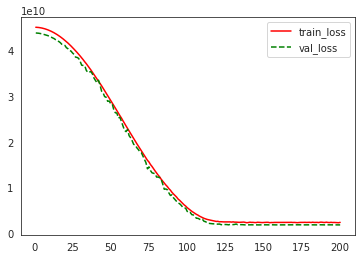

Training and validation MAE:


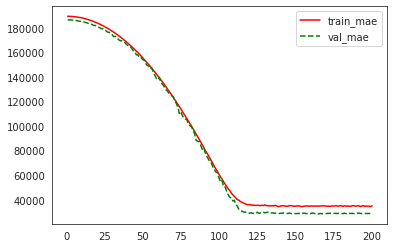

Learning rate:


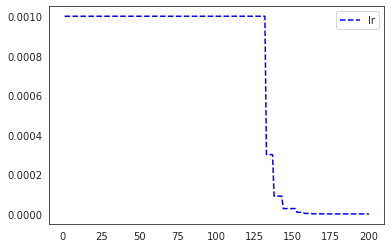

In [76]:
epochs = np.arange(1, len(history.history['loss'])+1)
print("epochs:", len(epochs))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'r-', label='train_loss')
plt.plot(epochs, val_loss, 'g--', label='val_loss')
plt.legend()
print("Training and validation loss:")
plt.show()

train_mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs, train_mae, 'r-', label='train_mae')
plt.plot(epochs, val_mae, 'g--', label='val_mae')
plt.legend()
print("Training and validation MAE:")
plt.show()

lr = history.history['lr']
plt.plot(epochs, lr, 'b--', label='lr')
plt.legend()
print("Learning rate:")
plt.show()

... and evaluate the model, both with the weights it had when the validation loss was at its lowest value, and at the end of the training process.

Since the loss function used here is mean squared error (MSE), we can compute root mean squared error (RMSE) by taking its root. This way we can compare this network's performance with other models.

In [77]:
model_last = models.load_model('model_last.h5')
model_last.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
print("\tLAST MODEL:")
model_last_train_score = model_last.evaluate(train_X, train_y, verbose=0)
print("Training set:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_last_train_score[0]), model_last_train_score[1]))
model_last_test_score = model_last.evaluate(test_X, test_y, verbose=0)
print("Testing set:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_last_test_score[0]), model_last_test_score[1]))
model_last_full_score = model_last.evaluate(data_X, data_y, verbose=0)
print("Full data:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_last_full_score[0]), model_last_full_score[1]))

model_best = models.load_model('model_best.h5')
model_best.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
print("\tBEST MODEL:")
model_best_train_score = model_best.evaluate(train_X, train_y, verbose=0)
print("Training set:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_best_train_score[0]), model_best_train_score[1]))
model_best_test_score = model_best.evaluate(test_X, test_y, verbose=0)
print("Testing set:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_best_test_score[0]), model_best_test_score[1]))
model_best_full_score = model_best.evaluate(data_X, data_y, verbose=0)
print("Full data:\tRMSE: %.4f\tMAE: %.4f" % (np.sqrt(model_best_full_score[0]), model_best_full_score[1]))

	LAST MODEL:
Training set:	RMSE: 41549.4385	MAE: 28141.1426
Testing set:	RMSE: 43098.4570	MAE: 29264.1895
Full data:	RMSE: 41706.9471	MAE: 28253.4688
	BEST MODEL:
Training set:	RMSE: 41526.8773	MAE: 28117.5879
Testing set:	RMSE: 43052.9096	MAE: 29220.8926
Full data:	RMSE: 41682.0222	MAE: 28227.9492


As you can see, "best" model does not do any better than the "last model". Also, looking at MAE could be misleading, when comparing its performance to other models, since RMSE almost 50% higher than MAEs in this case. Nevertheless, this network still performs much better even than random forests.

To have it all in one place, we'll make a dataframe containing RMSE scores of all the models tested so far.

In [78]:
scores_df = pd.DataFrame({
    'Models': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Sequential Neural Network'],
    'RMSE': [lr_cvs_rmse.mean(), dtr_cvs_rmse.mean(), rfr_cvs_rmse.mean(), np.sqrt(model_best_full_score[0])]
}).sort_values(by='RMSE', ascending=True).reset_index(drop=True)

scores_df

,Models,RMSE
0,Sequential Neural Network,41682.022216
1,Random Forest Regressor,52435.082121
2,Linear Regression,60044.489078
3,Decision Tree Regressor,74076.759128
